In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from diffusers import DDIMScheduler
import os

try:
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *
except ModuleNotFoundError:
    import os; os.chdir("..")
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *

%load_ext autoreload
%autoreload 2

/home/hamid/miniforge3/envs/geometric_diffusion_memorization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load model
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

model_id = "CompVis/stable-diffusion-v1-4"

pipe = LocalStableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    safety_checker=None,
    requires_safety_checker=False,
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
print(device)
pipe = pipe.to(device)

/home/hamid/miniforge3/envs/geometric_diffusion_memorization/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 11.27it/s]


cuda:1


In [3]:
num_inference_steps = 50
guidance_scale = 7.5
num_images_per_prompt = 4
image_size = 512

In [4]:
# prompt = "The No Limits Business Woman Podcast"
# prompt = "A painting of the Great Wave off Kanagawa by Katsushika Hokusai"
prompt = "Living in the Light with Ann Graham Lotz"
print(prompt)
seed = 0

Living in the Light with Ann Graham Lotz


## Before Mitigation

100%|██████████| 50/50 [00:03<00:00, 13.16it/s]


prompt: Living in the Light with Ann Graham Lotz


,,,

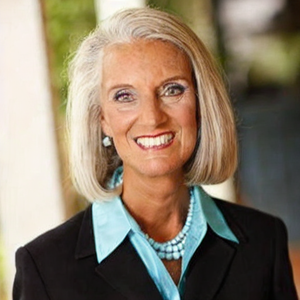
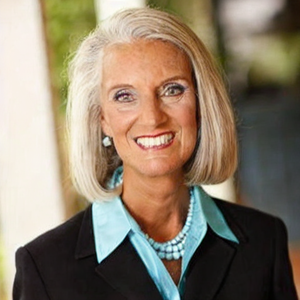
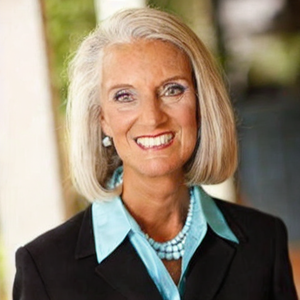
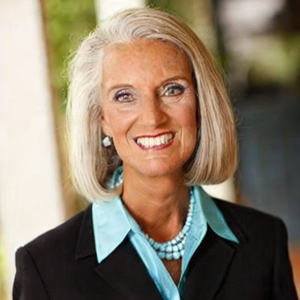

In [5]:
set_random_seed(seed)

outputs, track_stats = pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
)
outputs = outputs.images

print(f"prompt: {prompt}")
media.show_images(outputs, width=300)

## After Mitigation

In [6]:
method = "flipd"
auged_prompt_embeds = pipe.aug_prompt(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=1 if method == "flipd" else num_images_per_prompt,
    target_steps=[40],
    lr=0.5,
    optim_iters=30,
    print_optim=True,
    method=method,
)

 78%|███████▊  | 39/50 [00:00<00:00, 46.71it/s]/home/hamid/miniforge3/envs/geometric_diffusion_memorization/lib/python3.11/site-packages/torch/random.py:167: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)
 80%|████████  | 40/50 [00:23<00:05,  1.72it/s, loss=-1.3

100%|██████████| 50/50 [00:03<00:00, 12.88it/s]


<class 'PIL.Image.Image'>
prompt: Living in the Light with Ann Graham Lotz


,,,

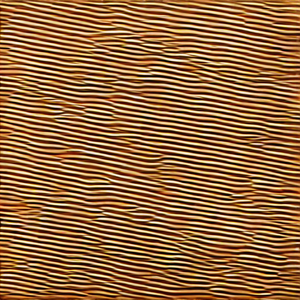
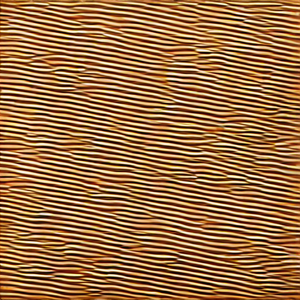
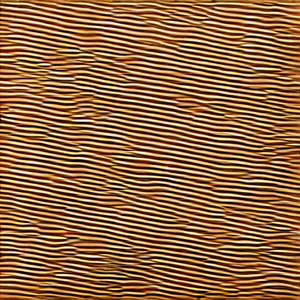
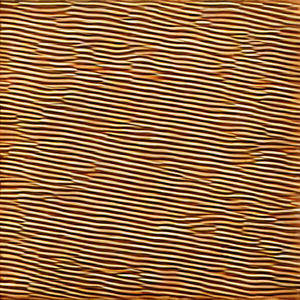

In [7]:
set_random_seed(seed)

outputs, track_stats = pipe(
    prompt_embeds=auged_prompt_embeds,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
    height=image_size,
    width=image_size,
)
outputs = outputs.images
print(type(outputs[0]))
print(f"prompt: {prompt}")
media.show_images(outputs, width=300)